In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/advertisingcsv/Advertising.csv


# Task 1: Importing Libraries

In [30]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import skew
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from yellowbrick.regressor import PredictionError, ResidualsPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor


plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (12,8)

# Task 2: Load the Data

The adverstiting dataset captures sales revenue generated with respect to advertisement spends across multiple channles like radio, tv and newspaper.


The dataset contains statistics about the sales of a product in 200 different markets, together with advertising budgets in each of these markets for different media channels: TV, radio and newspaper.
    
The sales are in thousands of units and the budget is in thousands of dollars (TV, radio, newspaper).

In [5]:
advert_df = pd.read_csv('../input/advertisingcsv/Advertising.csv')
advert_df.drop('Unnamed: 0', inplace=True, axis=1)
advert_df.columns = advert_df.columns.str.lower()
advert_df.head()

,tv,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [6]:
advert_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tv         200 non-null    float64
 1   radio      200 non-null    float64
 2   newspaper  200 non-null    float64
 3   sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


# Task 3: Relationship between Features and Response

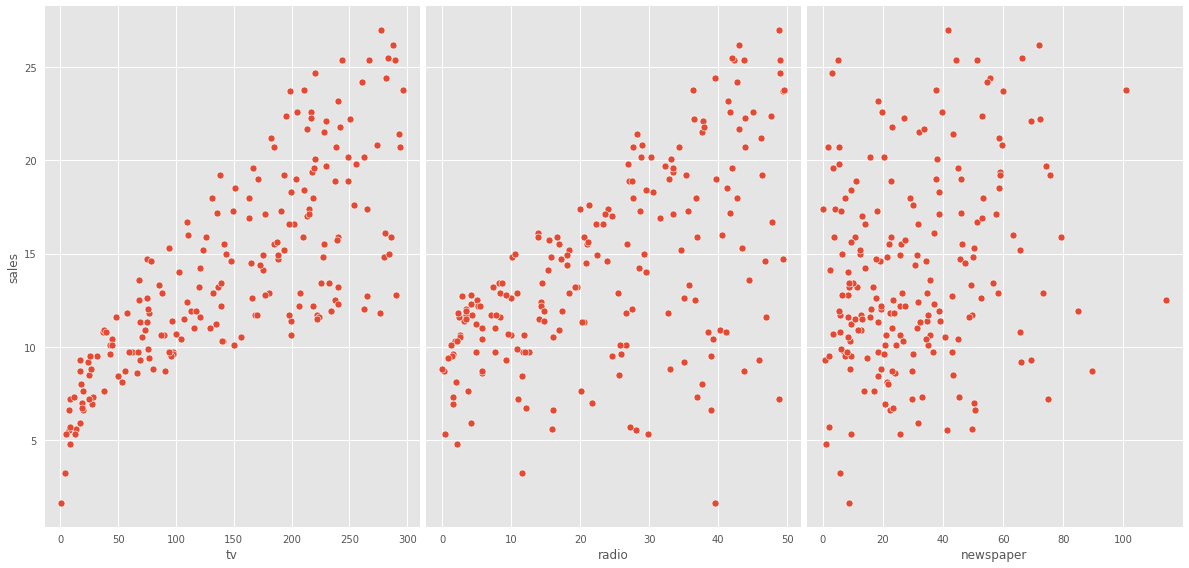

In [7]:
predictors = ['tv', 'radio', 'newspaper']
target = 'sales'
sns.pairplot(data=advert_df, x_vars=predictors, y_vars=target, height=8, aspect=0.7)

<AxesSubplot:>

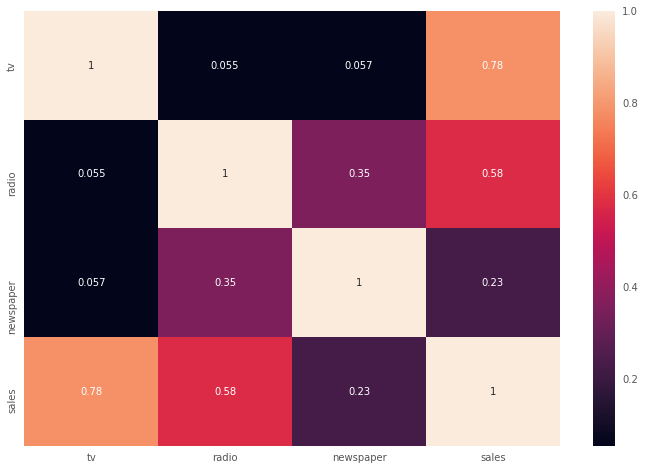

In [8]:
sns.heatmap(advert_df.corr(), annot=True)

* 'tv' and 'sales' have linear relationship
* 'radio' and 'sales' have linear relationship (weaker compared to the 1st pair)
* 'newspaper' and 'sales' non-linear

# Task 4: Multiple Linear Regression - Estimating Coefficients

In [9]:
X = advert_df[predictors]
y = advert_df[target]

lm1 = LinearRegression(fit_intercept=True)
lm1.fit(X, y)

print("Intercept : ", lm1.intercept_)
print("Slopes : ", lm1.coef_)

print("Slopes : ")
print("\t", list(zip(predictors, lm1.coef_)))

Intercept :  2.938889369459412
Slopes :  [ 0.04576465  0.18853002 -0.00103749]
Slopes : 
	 [('tv', 0.0457646454553976), ('radio', 0.18853001691820448), ('newspaper', -0.0010374930424763285)]


In [10]:
sm.OLS(endog=y, 
       exog=sm.add_constant(X)  # equivallent to sklearn fit_intercept
      ).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Sat, 24 Apr 2021   Prob (F-statistic):           1.58e-96
Time:                        19:15:10   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9389      0.312      9.422      0.000       2.324       3.554
tv             0.0458      0.001     32.809      0.000       0.043       0.049
radio          0.1885      0.009     21.893      0.000       0.172       0.206
newspaper     -0.0010      0.006     -0.177      0.860      -0.013       0.011
==============================================================================
Omnibus:                       60.414   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.241
Skew:                          -1.327   Prob(JB):                     1.44e-33
Kurtosis:                       6.332   Cond. No.                         454.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Task 5: Model Evaluation Using Train/Test Split and Metric

**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors: <h5 align=center>$$\frac{1}{n}\sum_{i=1}^{n} \left |y_i - \hat{y_i} \right |$$</h5>
**Mean Squared Error** (MSE) is the mean of the squared errors: <h5 align=center>$$\frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y_i})^2$$</h5>
**Root Mean Squared Error** (RMSE) is the mean of the squared errors: <h5 align=center>$$\sqrt{\frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y_i})^2}$$</h5>

! RMSE pinisher larger errors

In [11]:
def adj_r_squarred(model, X, y):
    return 1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)

### Model all predictors

In [12]:
X = advert_df[predictors]
y = advert_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

lm2 = LinearRegression().fit(X_train, y_train)
lm2_preds = lm2.predict(X_test)

print(f"RMSE \t : {np.sqrt(mean_squared_error(y_test, lm2_preds)):4f}")
print(f"R^2 \t : {r2_score(y_test, lm2_preds):.4f}")
print(f"Adj R^2  : {adj_r_squarred(lm2, X, y):.4f}")

RMSE 	 : 1.404651
R^2 	 : 0.9156
Adj R^2  : 0.8947


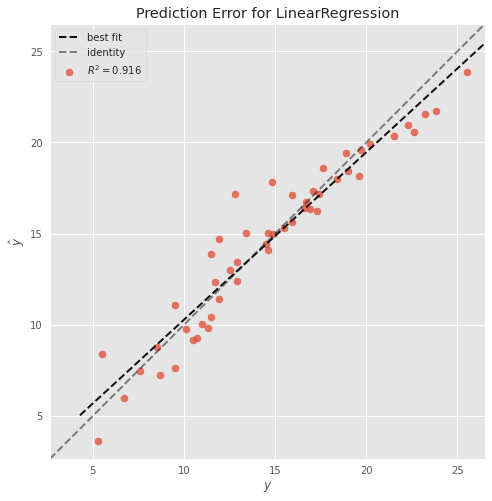

In [13]:
visualizer = PredictionError(lm2).fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof();

### Model without 'newspaper'

In [19]:
X = advert_df[['tv', 'radio']]
y = advert_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

lm3 = LinearRegression().fit(X_train, y_train)
lm3_preds = lm3.predict(X_test)

print(f"RMSE \t : {np.sqrt(mean_squared_error(y_test, lm3_preds)):4f}")
print(f"R^2 \t : {r2_score(y_test, lm3_preds):.4f}")
print(f"Adj R^2  : {adj_r_squarred(lm3, X, y):.4f}")

RMSE 	 : 1.387903
R^2 	 : 0.9176
Adj R^2  : 0.8956


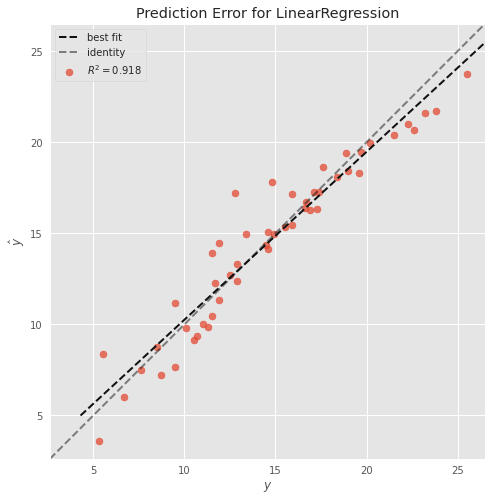

In [20]:
visualizer = PredictionError(lm3).fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof();

#### The second model is better. RMSE is lower while ADJ R^2 is higher

***
Notice that there is still some unexplained variability (the points which are far from the identiti/best fit ??? ). This may be due to non-linearity in the data or synergy effect that we are missing
***


# Task 7: Interaction Effect (Synergy)

***
Linear model with multiplicative assumption (all above were additive). Taking the product of two predictors (TV and radio). This is more realistic for certain datasets (like this one)

**'interaction_tv_radio'** could be interpret as the **increase in the effectivness of the TV advertising for 1 unit increase in radio advertising or vice versa**
***

In [21]:
advert_df['interaction_tv_radio'] = advert_df['tv'] * advert_df['radio'] 

X = advert_df[['tv', 'radio', 'interaction_tv_radio']]
y = advert_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

lm4 = LinearRegression().fit(X_train, y_train)
lm4_preds = lm4.predict(X_test)

print(f"RMSE \t : {np.sqrt(mean_squared_error(y_test, lm4_preds)):4f}")
print(f"R^2 \t : {r2_score(y_test, lm4_preds):.4f}")
print(f"Adj R^2  : {adj_r_squarred(lm4, X, y):.4f}")

RMSE 	 : 0.701187
R^2 	 : 0.9790
Adj R^2  : 0.9672


increase in the effectivness of the TV advertising for 1 unit increase in radio advertising or vice versa

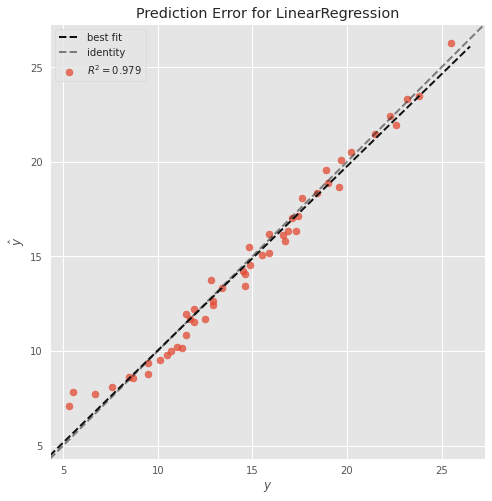

In [23]:
visualizer = PredictionError(lm4).fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof();

In [24]:
sm.OLS(endog=y, 
       exog=sm.add_constant(X)  # equivallent to sklearn fit_intercept
      ).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     1963.
Date:                Sat, 24 Apr 2021   Prob (F-statistic):          6.68e-146
Time:                        19:22:22   Log-Likelihood:                -270.14
No. Observations:                 200   AIC:                             548.3
Df Residuals:                     196   BIC:                             561.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    6.7502      0.248     27.233      0.000       6.261       7.239
tv                       0.0191      0.002     12.699      0.000       0.016       0.022
radio                    0.0289      0.009      3.241      0.001       0.011       0.046
interaction_tv_radio     0.0011   5.24e-05     20.727      0.000       0.001       0.001
==============================================================================
Omnibus:                      128.132   Durbin-Watson:                   2.224
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1183.719
Skew:                          -2.323   Prob(JB):                    9.09e-258
Kurtosis:                      13.975   Cond. No.                     1.80e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
advert_df.head()

,tv,radio,newspaper,sales,interaction_tv_radio
0,230.1,37.8,69.2,22.1,8697.78
1,44.5,39.3,45.1,10.4,1748.85
2,17.2,45.9,69.3,9.3,789.48
3,151.5,41.3,58.5,18.5,6256.95
4,180.8,10.8,58.4,12.9,1952.64


# VIF (Variance Inflation Factor) / Multicollinearity

1. https://www.statisticshowto.com/variance-inflation-factor/
2. https://statisticalhorizons.com/multicollinearity

***
Variance inflation factors range from 1 upwards. The numerical value for VIF tells you (in decimal form) what percentage the variance (i.e. the standard error squared) is inflated for each coefficient. For example, a VIF of 1.9 tells you that the variance of a particular coefficient is 90% bigger than what you would expect if there was no multicollinearity — if there was no correlation with other predictors.

A rule of thumb for interpreting the variance inflation factor:

*     1 = not correlated.
*     Between 1 and 5 = moderately correlated.
*     Greater than 5 = highly correlated.

Exactly how large a VIF has to be before it causes issues is a subject of debate. What is known is that the more your VIF increases, the less reliable your regression results are going to be. **In general, a VIF above 10 indicates high correlation and is cause for concern. Some authors suggest a more conservative level of 2.5 or above.**

**Sometimes a high VIF is no cause for concern at all. For example, you can get a high VIF by :**

* including products or powers from other variables in your regression, like x and x2. 
* If you have high VIFs for dummy variables representing nominal variables with three or more categories, those are usually not a problem.
* The variables with high VIFs are control variables, and the variables of interest do not have high VIFs

For more details check : https://statisticalhorizons.com/multicollinearity
***

In [36]:
# the independent variables set
X = advert_df[['tv', 'radio', 'newspaper', 'interaction_tv_radio']]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

                feature       VIF
0                    tv  4.416728
1                 radio  5.886059
2             newspaper  3.283250
3  interaction_tv_radio  6.906337
